## Toxicity Prediction Demo (NR-AR)

This notebook demonstrates how the final Random Forest model can be used to
predict toxicity for new chemical structures provided as SMILES strings.


In [2]:
# ====================
# Load Model + Config
# ====================

import joblib

rf_model = joblib.load("tox21_nr_ar_random_forest.joblib")
fp_config = joblib.load("fp_config.joblib")


In [3]:
# ==============================================
# Feature Builder: Fingerprints and Descriptors
# ==============================================

import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.DataStructs import ConvertToNumpyArray

# Must match your notebook order exactly:
DESCRIPTOR_ORDER = ["MolWt", "LogP", "TPSA", "HBD", "HBA", "RotatableBonds", "AromaticRings"]

def compute_descriptors(mol):
    return np.array([
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumAromaticRings(mol),
    ], dtype=float)

def smiles_to_features(smiles: str):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")

    # 2048-bit Morgan fingerprint
    n_bits = fp_config["n_bits"]
    radius = fp_config["radius"]
    use_chirality = fp_config.get("use_chirality", False)

    fp = Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(
        mol, radius=radius, nBits=n_bits, useChirality=use_chirality
    )
    fp_arr = np.zeros((n_bits,), dtype=np.int8)
    ConvertToNumpyArray(fp, fp_arr)

    # 7 descriptors
    desc_arr = compute_descriptors(mol)  # shape (7,)

    # Final feature vector: [fingerprints | descriptors]
    X = np.hstack([fp_arr.astype(float), desc_arr]).reshape(1, -1)
    return mol, X


In [4]:
# =================
# Test Prediction (aspirin)
# =================

smiles = "CC(=O)Oc1ccccc1C(=O)O"
mol, X = smiles_to_features(smiles)

print("Feature vector shape:", X.shape)          
print("Model expects:", rf_model.n_features_in_)

prob_toxic = rf_model.predict_proba(X)[0, 1]
pred = int(prob_toxic >= 0.5)

print(f"Toxicity probability: {prob_toxic:.3f}")
print("Prediction:", "Toxic (1)" if pred == 1 else "Non-toxic (0)")


Feature vector shape: (1, 2055)
Model expects: 2055
Toxicity probability: 0.007
Prediction: Non-toxic (0)


[19:46:54] DEPRECATION WARNING: please use MorganGenerator


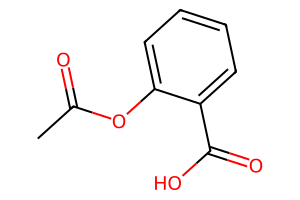

In [5]:
# ===================
# Visualize Molecule
# ===================

from rdkit.Chem import Draw

Draw.MolToImage(mol, size=(300, 200))
